# Disparities in State Voter Turnout: Culture or Policy?

Political scientists, for decades have often debated whether the low voter turnout in the USA is a question of cultural norms or voting policies. Many believe that even if we were to make voting in the United States substantially easier, we wouldn’t see large increases in turnout because the culture of voting doesn’t exist. What is often used is state by state data, where some political scientists will argue that because some states make it easier to vote, they have higher voter turnout rates (e.g. Minnesota), and the ones that don’t, see lower turnout rates (e.g. Georgia). Opponents of this theory will say that Minnesotans were always voting at a high level, and that culture of wanting to vote is what drove the policy changes, not the other way around. The way this has been traditionally studied is by grouping states into “cultural/geographic” segments, and then comparing turnout among them. 
	
Our project plan is to use data available from previous elections to test whether the differences among different states is cultural or policy oriented. We plan on doing this by constructing a data set that quantifies cultural things (i.e. demographics, geography, history of voter turnout, education rates, political participation in other forms), and using that to predict voter turnout rates. We’ll create a few training sets for regional groups, and then after training an algorithm on that, we’ll use it to compare different test sets to see if our predicted turnout rates differ from actual turnout rates. If the turnout rate of a state is predicted to be much higher than it is in reality, then one could argue that the cultural factors aren’t as important, and that there are policies in place that are preventing people from voting.

First, we import the librarie we will be using throughout the course of the project:

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

C:\Users\Stephen\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Here we will read in the 2009 and 2014 datasets, which will serve as the training dand testing data, respectively.

In [2]:
# Read in 2009 and 2014 datasets
filename2009 = 'https://raw.githubusercontent.com/prathmj/SocialCapitalTurnoutStudy/master/Social%20Capital%202009%20with%20turnout.csv'
filename2014 = 'https://raw.githubusercontent.com/prathmj/SocialCapitalTurnoutStudy/master/Social%20Capital%202014%20with%20turnout.csv'
data2009 = pd.read_csv(filename2009)
data2014 = pd.read_csv(filename2014)

print("2009:")
print(data2009.head())
print("2014:")
print(data2014.head())

2009:
   fips  statcode     areaname  relig  civic  bus  pol  prof  labor  bowl  \
0  1001         1  Autauga, AL   50.0    7.0  3.0  NaN   1.0    5.0   1.0   
1  1003         1  Baldwin, AL  161.0   21.0  7.0  NaN   1.0    2.0   2.0   
2  1005         1  Barbour, AL   17.0    1.0  1.0  NaN   NaN    1.0   1.0   
3  1007         1     Bibb, AL   27.0    NaN  1.0  NaN   NaN    NaN   NaN   
4  1009         1   Blount, AL   42.0    1.0  1.0  NaN   NaN    1.0   NaN   

   fitns  golf  sport       pop  respn   nccs      assn     pvote  
0    4.0   2.0    NaN   50756.0   0.78  182.0  1.438254  0.635648  
1   18.0   8.0    NaN  179878.0   0.73  737.0  1.223051  0.608996  
2    1.0   2.0    NaN   29737.0   0.63  107.0  0.807075  0.512425  
3    1.0   1.0    NaN   21587.0   0.58   59.0  1.389725  0.522517  
4    3.0   4.0    NaN   58345.0   0.80  121.0  0.891250  0.555640  
2014:
   FIPS  relig  civic  bus  pol  prof  labor  bowl  fitns  golf  sport  \
0  1001   53.0    7.0  3.0  NaN   1.0    4.

Before we start to train any models, a bit of preprocessing is required, as performed below:

In [3]:
# delete missing counties in the 2009 dataset
fips2009 = data2009['fips'].tolist()
fips2014 = data2014['FIPS'].tolist()

index = 0
toDelete = []
for fip in fips2014:
    if fip not in fips2009:
        toDelete.append(index)
    index = index + 1
data2014 = data2014.drop(toDelete, axis=0)

index = 0
toDelete = []
for fip in fips2009:
    if fip not in fips2014:
        toDelete.append(index)
    index = index + 1
data2009 = data2009.drop(toDelete, axis=0)
        
data2009 = data2009.drop(['fips', 'areaname', 'statcode'], axis=1)
data2014 = data2014.drop(['FIPS'], axis=1)

# Impute missing values with 0
data2009 = data2009.fillna(value=0)
data2014 = data2014.fillna(value=0)

# Separate into x and y
X2009 = data2009.iloc[:, :-1]  # features
y2009 = data2009.iloc[:, -1]  # class (turnout)

X2014 = data2014.iloc[:, :-1]  # features
y2014 = data2014.iloc[:, -1]  # class (turnout)

print("2009:")
print(data2009.head())
print("2014:")
print(data2014.head())

2009:
   relig  civic  bus  pol  prof  labor  bowl  fitns  golf  sport       pop  \
0   50.0    7.0  3.0  0.0   1.0    5.0   1.0    4.0   2.0    0.0   50756.0   
1  161.0   21.0  7.0  0.0   1.0    2.0   2.0   18.0   8.0    0.0  179878.0   
2   17.0    1.0  1.0  0.0   0.0    1.0   1.0    1.0   2.0    0.0   29737.0   
3   27.0    0.0  1.0  0.0   0.0    0.0   0.0    1.0   1.0    0.0   21587.0   
4   42.0    1.0  1.0  0.0   0.0    1.0   0.0    3.0   4.0    0.0   58345.0   

   respn   nccs      assn     pvote  
0   0.78  182.0  1.438254  0.635648  
1   0.73  737.0  1.223051  0.608996  
2   0.63  107.0  0.807075  0.512425  
3   0.58   59.0  1.389725  0.522517  
4   0.80  121.0  0.891250  0.555640  
2014:
   relig  civic  bus  pol  prof  labor  bowl  fitns  golf  sport     pop  \
0   53.0    7.0  3.0  0.0   1.0    4.0   1.0    5.0   2.0    0.0   55290   
1  169.0   16.0  9.0  0.0   3.0    1.0   1.0   25.0   7.0    0.0  199713   
2   19.0    1.0  1.0  0.0   0.0    0.0   0.0    0.0   1.0    0.

Next, we will visualize the data using various graphs:

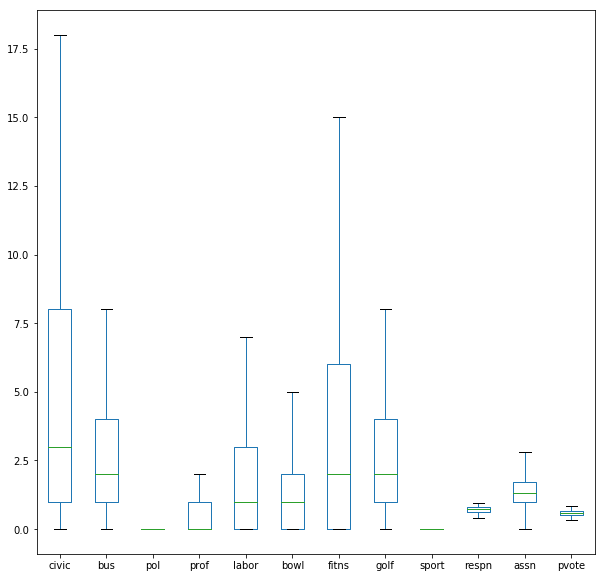

In [4]:
box2009 = data2009.drop(['relig', 'pop', 'nccs'], axis=1).plot.box(grid=False, figsize=(10,10), showfliers=False)

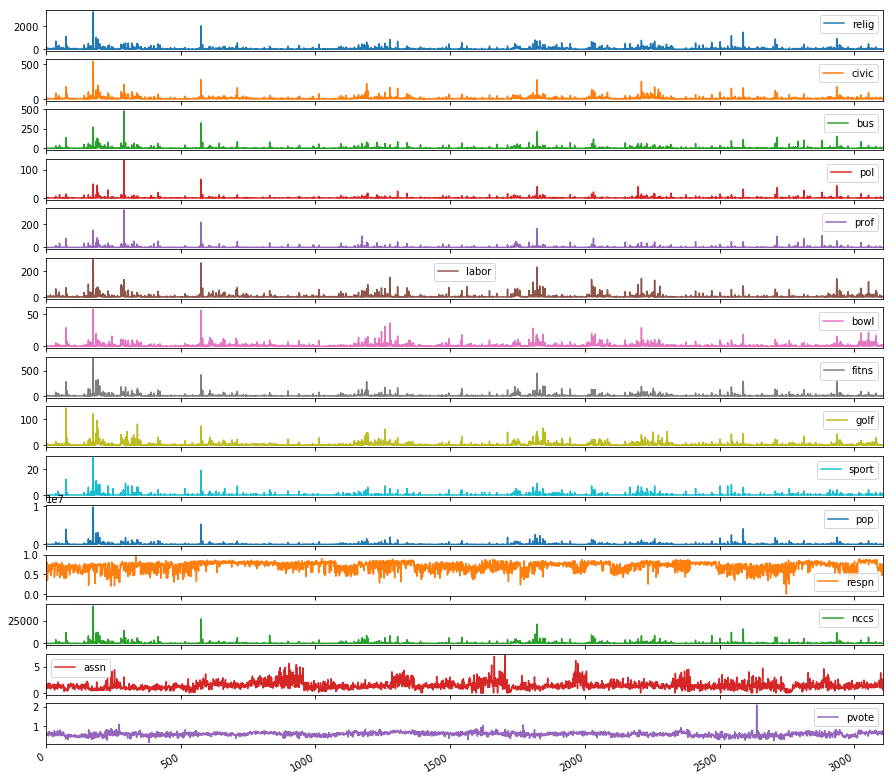

In [5]:
plot2009 = data2009.plot(figsize=(15, 15), subplots=True)

Here we will perform Principal Component Analysis (PCA) on the 2009 dataset.

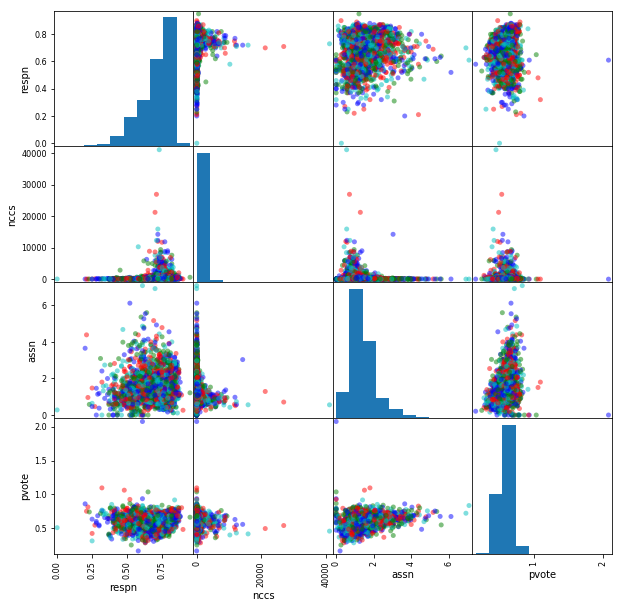

In [6]:
my_colors = ['g', 'b', 'r', 'c']
scatter = pd.plotting.scatter_matrix(data2009.iloc[:, 11:15], diagonal='hist', figsize=(10,10), color=my_colors, s=100)

[  9.99997242e-01   2.74213880e-06   1.28159604e-08]


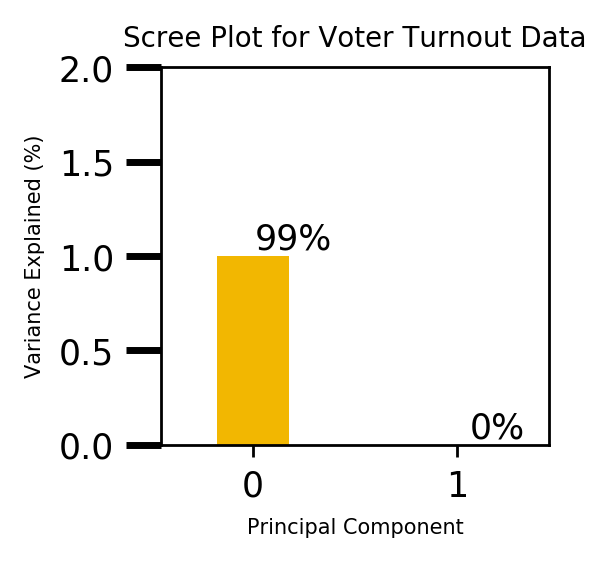

In [7]:
from sklearn import decomposition
# Projection onto the first 2 principal components.

Xpca = X2009

# Global centering.
data_centered = Xpca - Xpca.mean()
    
pca = decomposition.PCA(n_components=3)
data_pca = pca.fit_transform(data_centered.dropna())

print(pca.explained_variance_ratio_)

# Generate scree plot.
N = 3
ind = np.arange(N)  # the x locations for the groups

vals = pca.explained_variance_ratio_

plt.figure(figsize=(2, 2), dpi=250)
ax = plt.subplot(111)
ax.bar(ind, pca.explained_variance_ratio_, 0.35, 
       color=[(0.949, 0.718, 0.004),
              (0.898, 0.49, 0.016),
              (0.863, 0, 0.188)
             ])

ax.annotate(r"%d%%" % (int(vals[0]*100)), (ind[0]+0.2, vals[0]), va="bottom", ha="center", fontsize=10)
ax.annotate(r"%d%%" % (int(vals[1]*100)), (ind[1]+0.2, vals[1]), va="bottom", ha="center", fontsize=10)
ax.annotate(r"%d%%" % (int(vals[2]*100)), (ind[2]+0.2, vals[2]), va="bottom", ha="center", fontsize=10)

ax.set_ylim(0, 2)
ax.set_xlim(0-0.45, 1+0.45)

ax.yaxis.set_tick_params(width=2, length=10)

ax.set_xlabel("Principal Component", fontsize=6)
ax.set_ylabel("Variance Explained (%)", fontsize=6)

plt.title("Scree Plot for Voter Turnout Data", fontsize=8)

Next, we will finally perform Linear Regression to predict what the 2014 voter turnout should be based upon the 2009 data.

In [8]:
regr = LinearRegression()

# train data on 2009 data set
regr.fit(X2009.iloc[:, :-3], y2009)

# predict on 2014 data
y_pred = regr.predict(X2014.iloc[:, :-3])

print (y_pred)

[ 0.58390294  0.57712156  0.58033503 ...,  0.58947388  0.59097417
  0.58555513]


In [9]:
print(np.average((y2014 - y_pred) ** 2))

0.0145169611548


In [18]:
#y2014 = y2014.tolist()

largestDiffs = []
count = 0
# loop through real and predicted values
# pick out indices that exceed threshold of .45 between real and predicted values
for i in range(len(y2014)):
    real = y2014[i]
    pred = y_pred[i]
    if real + 0.4 < pred or real - 0.4 > pred:
        largestDiffs.append(count)
    count = count + 1
    
print (len(largestDiffs))
print(largestDiffs)

for i in largestDiffs:
    print(data2014.iloc[i, :])

14
[175, 3083, 3085, 3086, 3087, 3089, 3090, 3093, 3094, 3095, 3097, 3099, 3101, 3103]
relig    3.275000e+03
civic    5.460000e+02
bus      2.830000e+02
pol      7.600000e+01
prof     1.350000e+02
labor    2.830000e+02
bowl     4.600000e+01
fitns    8.450000e+02
golf     1.140000e+02
sport    3.700000e+01
pop      1.010944e+07
respn    5.578946e-01
nccs     7.300000e-01
assn     3.754700e+04
pvote    6.685109e-01
Name: 204, dtype: float64
relig       29.000000
civic        8.000000
bus          2.000000
pol          0.000000
prof         0.000000
labor        0.000000
bowl         1.000000
fitns        4.000000
golf         0.000000
sport        0.000000
pop      37918.000000
respn        1.160399
nccs         0.720000
assn       324.000000
pvote        1.065220
Name: 3118, dtype: float64
relig       22.000000
civic        8.000000
bus          2.000000
pol          1.000000
prof         0.000000
labor        3.000000
bowl         2.000000
fitns        5.000000
golf         1.000000
sp